In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import colors as c
import seaborn
import statistics
import time
import json


In [2]:
# For Neural Network
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, InputLayer,Dense

from keras.utils import np_utils

# Naive Bayes Classifier

### Training Functions

In [3]:
def get_probability_of_labels(training_data_df):
    # Get the count of each label value
    len_of_training = len(training_data_df)
    counter_of_labels = Counter(training_data_df['Label'].to_numpy())
    # Get the probability of each label
    probability_of_labels = {}
    for i in counter_of_labels.keys():
        probability_of_labels[i] = counter_of_labels[i]/len_of_training
    return probability_of_labels, counter_of_labels
    # Image size 28 x 28

In [4]:
def get_probability_of_features(training_data_df, counter_of_labels):
    # Used to store the probability of each grid
    dict_of_g = {}
    # Used to identify the split points based on the label values
    split_list = []
    temp = 0
    for i in range(10):
        temp += counter_of_labels[i]
        split_list.append(temp)
    # Get the number of features from the data
    no_of_features = len(training_data_df.iloc[0])-2

    # We split the G values based on the labels
    for i in range(no_of_features):
        dict_of_g['G'+str(i)] = np.split(training_data_df['G'+str(i)].to_numpy(),split_list)

    # Get the probability of each feature
    probability_of_features = {}
    cnt = 0
    for i in range(no_of_features):
        temp = {}
        for j in range(10):
            temp[j] = dict(Counter(dict_of_g['G'+str(i)][j]))
            # since each feature is of size 4x4 there are 16 pixels and 17 combinations
            for k in range(17):
                cnt+=1
                if(k not in temp[j]):
                    temp[j][k] = 10**-4
                else:
                    temp[j][k] /= counter_of_labels[j]
        probability_of_features['G'+str(i)] = temp
    return probability_of_features, no_of_features
    # Probability of features levels
    # [Grid_number][Label][No. of Black pixels]

### Testing Functions

In [5]:
# Testing on the entire data
def perform_testing (testing_data_df, probability_of_features, probability_of_labels):
    # Keep track of correct predictions
    true_cases = 0

    no_of_features = len(testing_data_df.iloc[0])-2

    # To print the confusion matrix 
    confusion_matrix_values = np.zeros((10,10))

    len_of_testing = len(testing_data_df)
    testing_labels = testing_data_df['Label'].to_numpy()

    # Iterate over the testing data
    for i in range(len_of_testing):
        current_test_data = testing_data_df.iloc[i]
        # Contains the probability of each feature for the given data point
        dict_of_final_probabilities = {}
        # 10 features
        for l in range(10):
            temp_prod = 1
            # Get the probability of each feature from the dictionary of probabilities
            for g in range(no_of_features):
                temp_prod *= probability_of_features['G'+str(g)][l][current_test_data['G'+str(g)]]
            dict_of_final_probabilities[l] = temp_prod*probability_of_labels[l]
        # True prediction
        if(testing_labels[i] == max(dict_of_final_probabilities, key=dict_of_final_probabilities.get)):
            true_cases+=1
            confusion_matrix_values[testing_labels[i]][testing_labels[i]]+=1
        # False prediction
        else:
            confusion_matrix_values[testing_labels[i]][max(dict_of_final_probabilities, key=dict_of_final_probabilities.get)] += 1
    
    accuracy = (true_cases*100)/len_of_testing
    return accuracy, confusion_matrix_values
    



In [6]:
# Perform test on a random sample
def random_naive_test(test_df, probability_of_features, probability_of_labels):
    current_df = test_df.iloc[0]
    label = current_df['Label']
    dict_of_final_probabilities = {}
    no_of_features = len(test_df.iloc[0])-2
    for l in range(10):
        temp_prod = 1
        for g in range(no_of_features):
            temp_prod *= probability_of_features['G'+str(g)][l][current_df['G'+str(g)]]
        dict_of_final_probabilities[l] = temp_prod*probability_of_labels[l]
    return max(dict_of_final_probabilities, key=dict_of_final_probabilities.get), label
        


### Training on the entire dataset

In [7]:
# Get the data
training_data_df = pd.read_csv('./data/digitdata/fortyninetrainfeatures.csv')
training_data_df = pd.concat([training_data_df, pd.read_csv('./data/digitdata/fortyninevalidationfeatures.csv')])
testing_data_df = pd.read_csv('./data/digitdata/fortyninetestfeatures.csv')


In [8]:
# Train on the entire data
training_data_df  = training_data_df.sort_values('Label')
start_time = time.time()
probability_of_labels, counter_of_labels = get_probability_of_labels(training_data_df)
probability_of_features, no_of_features = get_probability_of_features(training_data_df, counter_of_labels)
print("Training time :", time.time()-start_time,'s')


Training time : 0.038893938064575195 s


### Testing after training on entire dataset

In [9]:
accuracy, confusion_matrix_values = perform_testing(testing_data_df, probability_of_features, probability_of_labels)

Accuracy: 76.4


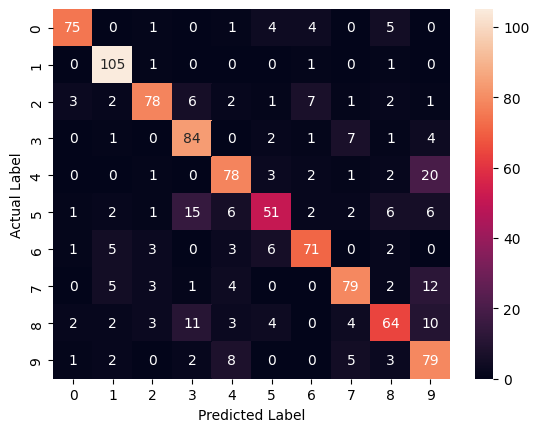

In [10]:
print("Accuracy:",accuracy)
# Generate confusion matrix
dataframe_confusion_matrix = pd.DataFrame(confusion_matrix_values, range(10), range(10))
heatmap = seaborn.heatmap(dataframe_confusion_matrix, annot=True, fmt='g')
heatmap.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.show()

### Training on subdivisions of dataset

In [11]:
mean_list = []
# The two std lists will show how much do the values deviate from the mean in our samples
std_low = []
std_high = []
time_list = []
no_of_datapoints = []
# Iterate over different sample size
for perc in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    accuracy_list = []
    temp_times = []
    # 5 random dataset
    for s in range(5):
        sample_training_df = training_data_df.sample(frac=perc, random_state=s)
        sample_training_df  = sample_training_df.sort_values('Label')
        # Get the training time
        start_time = time.time()
        probability_of_labels, counter_of_labels = get_probability_of_labels(sample_training_df)
        probability_of_features, no_of_features = get_probability_of_features(sample_training_df, counter_of_labels)
        temp_times.append(time.time() - start_time)
        accuracy, confusion_matrix_values = perform_testing(testing_data_df, probability_of_features, probability_of_labels)
        accuracy_list.append(accuracy)
    no_of_datapoints.append(len(sample_training_df))
    time_list.append(statistics.mean(temp_times))
    mean = statistics.mean(accuracy_list)
    mean_list.append(mean)
    std_dev = statistics.stdev(accuracy_list)
    std_low.append(mean-std_dev)
    std_high.append(mean+std_dev)


In [12]:
print("Mean Values:", mean_list)
print("Size of Training data", no_of_datapoints)

Mean Values: [65.2, 72.28, 73.98, 75.22, 76.12, 75.92, 75.98, 76.12, 76.62, 76.4]
Size of Training data [600, 1200, 1800, 2400, 3000, 3600, 4200, 4800, 5400, 6000]


### Plotting results

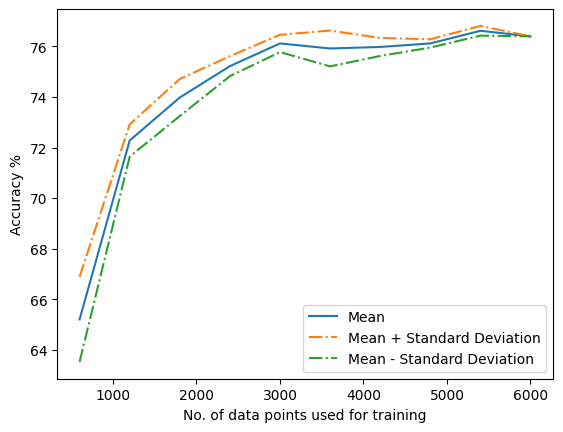

In [13]:
# Plot the graph of mean and standard deviation
plt.plot(no_of_datapoints, mean_list,label="Mean")
plt.plot(no_of_datapoints, std_high,'-.',label="Mean + Standard Deviation")
plt.plot(no_of_datapoints, std_low,'-.', label="Mean - Standard Deviation")
plt.xlabel("No. of data points used for training")
plt.ylabel("Accuracy %")
plt.legend()
plt.show()


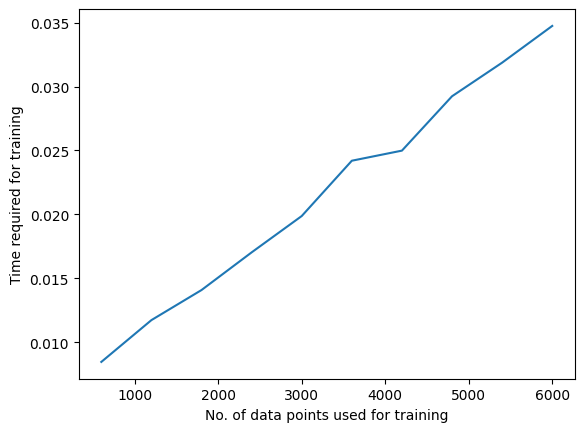

In [14]:
# Running time graph
plt.plot(no_of_datapoints, time_list)
plt.xlabel("No. of data points used for training")
plt.ylabel("Time required for training")
plt.show()

# Perceptron

### Training Functions

In [15]:
def initialize_weights(image_size , number_classes):
  weights = []
  for i in range(number_classes):
    weights.append( [0 for i in range(image_size*image_size+1)] )
  return weights

In [16]:
def f(data,w):
  x = list( np.array(data).flat )
  return np.dot(x,w[1:])+w[0]

In [17]:
def update(data,w,sign):
  x = list( np.array(data).flat )
  w[0] = w[0] + (sign * 1)
  for i in range( len(x) ):
    w[i+1] = w[i+1] + (sign * x[i])

In [18]:
def predict_value(input,weights):
  return np.argmax( [ f(input,weights[i]) for i in range(len(weights))] )

In [19]:
def train_perceptron(df,weights):
  start_time = time.time()
  change=1
  itr = 0
  while(change!=0 and itr<1000 ):
    change=0
    for row in df.itertuples():
      data = row[1]
      label = row[2]
      pred = predict_value(data,weights)
      if(pred!=label):
        update(data,weights[label],1)
        update(data,weights[pred],-1)
        change+=1
    itr += 1
  time_taken = time.time()-start_time
  print("Training Completed in",itr,"Iterations")
  print("Time Taken : ",time_taken)
  return time_taken

In [20]:
def train_perceptron(df,weights):
  start_time = time.time()
  change=1
  itr = 0
  while(change!=0 and itr<1000 ):
    change=0
    for row in df.itertuples():
      data = row[1]
      label = row[2]
      pred = predict_value(data,weights)
      if(pred!=label):
        update(data,weights[label],1)
        update(data,weights[pred],-1)
        change+=1
    itr += 1
  time_taken = time.time()-start_time
  print("Training Completed in",itr,"Iterations")
  print("Time Taken : ",time_taken)
  return time_taken

In [21]:
def display_image(data):
    cMap = c.ListedColormap( ['black', 'white'] )
    plot = plt.pcolormesh(data, cmap=cMap)
    plot.axes.set_aspect('equal')  
    plt.xticks([])  
    plt.yticks([])  
    plot.axes.invert_yaxis()
    plt.show()

In [22]:
def accuracy(df,weights):
  count = 0
  for row in df.itertuples():
    ans = predict_value( row[1] ,weights)
    if(ans == row[2]):
      count +=1
  return count/len(df)

In [23]:
def perceptron_accuracy(train,test):
  weights = initialize_weights(28,10)
  Time = train_perceptron(train,weights)
  return accuracy(test,weights),Time

### Training on entire dataset

In [24]:
filepath = './data'

In [25]:
train_df = pd.read_csv(filepath+"/digitdata/traindata.csv", index_col=False)
train_df['Image_data'] = train_df['Image_data'].apply(json.loads)

In [26]:
validation_df = pd.read_csv(filepath+"/digitdata/validationdata.csv", index_col=False)
validation_df['Image_data'] = validation_df['Image_data'].apply(json.loads)

In [27]:
test_df = pd.read_csv(filepath+"/digitdata/testdata.csv", index_col=False)
test_df['Image_data'] = test_df['Image_data'].apply(json.loads)

In [28]:
train_valid_df = train_df.append( validation_df , ignore_index = True )

In [36]:
size = 28
labels_count = 10
weights = initialize_weights(size,labels_count)
time_taken = train_perceptron(train_valid_df,weights)

Training Completed in 201 Iterations
Time Taken :  1909.0981113910675


### Saving weights

In [ ]:
weights_df = pd.DataFrame(columns = ['Weights'])

weights_df['Weights']=weights
weights_df

,Weights
0,"[-31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,"[43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[-40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,"[50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
5,"[146, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
6,"[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,"[127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
8,"[-275, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,"[-63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [ ]:
weights_df.to_csv(filepath+"/digitdata/weightsnew.csv", index=False)

### Testing Function

In [29]:
def performance(weight,df):
  count=0
  confusion_matrix_values = np.zeros((10,10))
  for row in df.itertuples():
    ans = predict_value( row[1] ,weight)
    if(ans == row[2]):
      count +=1
    confusion_matrix_values[row[2]][ans]+=1
  
  print("Accuracy",count/len(df))

  dataframe_confusion_matrix = pd.DataFrame(confusion_matrix_values, range(10), range(10))
  heatmap = seaborn.heatmap(dataframe_confusion_matrix, annot=True, fmt='g')
  heatmap.set(xlabel='Predicted Values', ylabel='Actual Values')

In [30]:
# Retreive weights
weights_df = pd.read_csv(filepath+"/weights/weightsnew.csv", index_col=False)
weights_df['Weights'] = weights_df['Weights'].apply(json.loads)
weights = weights_df['Weights'].tolist()

Accuracy 0.826


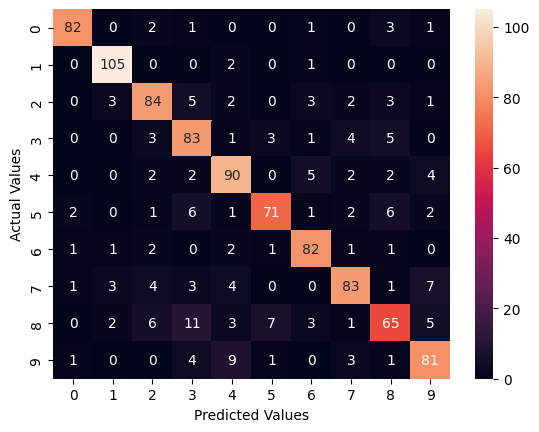

In [31]:
performance(weights,test_df)

In [32]:
def random_perceptron_test(test_digit_df, weights):
    current_df = test_digit_df.iloc[0]
    ans = predict_value( current_df['Image_data'] ,weights)
    label = current_df['Label']
    return ans, label


### Training on subdivisions of dataset

In [32]:
Mean = []
Std  = []
Time = []

In [ ]:
train_size = 0.1
print("Train Size :",train_size)
print()
acc = []
time_list=[]
for i in range(5):
  temp,temp_time = perceptron_accuracy(train_valid_df.sample(frac = train_size, random_state = i), test_df )
  print("Accuracy : ",temp)
  acc.append(temp)
  time_list.append(temp_time)
  print()
print("Mean : ",np.mean(acc) )
print("Std  : ",np.std(acc,ddof=1))
print("Time : ",np.mean(time_list))
Mean.append(np.mean(acc))
Std.append(np.std(acc,ddof=1))
Time.append(np.mean(time_list))

Train Size : 0.1

Training Completed in 18 Iterations
Time Taken :  18.719452619552612
Accuracy :  0.781

Training Completed in 24 Iterations
Time Taken :  25.742564916610718
Accuracy :  0.794

Training Completed in 19 Iterations
Time Taken :  20.973567008972168
Accuracy :  0.768

Training Completed in 11 Iterations
Time Taken :  12.560858964920044
Accuracy :  0.801

Training Completed in 17 Iterations
Time Taken :  17.993113040924072
Accuracy :  0.799

Mean :  0.7886
Std  :  0.01390323703315168
Time :  19.197911310195924


In [ ]:
train_size = 0.2
print("Train Size :",train_size)
print()
acc = []
time_list=[]
for i in range(5):
  temp,temp_time = perceptron_accuracy(train_valid_df.sample(frac = train_size, random_state = i), test_df )
  print("Accuracy : ",temp)
  acc.append(temp)
  time_list.append(temp_time)
  print()
print("Mean : ",np.mean(acc) )
print("Std  : ",np.std(acc,ddof=1))
print("Time : ",np.mean(time_list))
Mean.append(np.mean(acc))
Std.append(np.std(acc,ddof=1))
Time.append(np.mean(time_list))

Train Size : 0.2

Training Completed in 20 Iterations
Time Taken :  43.670793533325195
Accuracy :  0.819

Training Completed in 34 Iterations
Time Taken :  70.16207480430603
Accuracy :  0.801

Training Completed in 28 Iterations
Time Taken :  60.984384536743164
Accuracy :  0.813

Training Completed in 25 Iterations
Time Taken :  52.997578144073486
Accuracy :  0.796

Training Completed in 46 Iterations
Time Taken :  97.88118386268616
Accuracy :  0.793

Mean :  0.8044
Std  :  0.011171392035015104
Time :  65.13920297622681


In [ ]:
train_size = 0.3
print("Train Size :",train_size)
print()
acc = []
time_list=[]
for i in range(5):
  temp,temp_time = perceptron_accuracy(train_valid_df.sample(frac = train_size, random_state = i), test_df )
  print("Accuracy : ",temp)
  acc.append(temp)
  time_list.append(temp_time)
  print()
print("Mean : ",np.mean(acc) )
print("Std  : ",np.std(acc,ddof=1))
print("Time : ",np.mean(time_list))
Mean.append(np.mean(acc))
Std.append(np.std(acc,ddof=1))
Time.append(np.mean(time_list))

Train Size : 0.3

Training Completed in 39 Iterations
Time Taken :  126.11778903007507
Accuracy :  0.825

Training Completed in 37 Iterations
Time Taken :  117.59451007843018
Accuracy :  0.799

Training Completed in 42 Iterations
Time Taken :  136.6428940296173
Accuracy :  0.83

Training Completed in 41 Iterations
Time Taken :  129.71429109573364
Accuracy :  0.821

Training Completed in 31 Iterations
Time Taken :  101.61519527435303
Accuracy :  0.806

Mean :  0.8162
Std  :  0.013141537200799561
Time :  122.33693590164185


In [ ]:
train_size = 0.4
print("Train Size :",train_size)
print()
acc = []
time_list=[]
for i in range(5):
  temp,temp_time = perceptron_accuracy(train_valid_df.sample(frac = train_size, random_state = i), test_df )
  print("Accuracy : ",temp)
  acc.append(temp)
  time_list.append(temp_time)
  print()
print("Mean : ",np.mean(acc) )
print("Std  : ",np.std(acc,ddof=1))
print("Time : ",np.mean(time_list))
Mean.append(np.mean(acc))
Std.append(np.std(acc,ddof=1))
Time.append(np.mean(time_list))

Train Size : 0.4

Training Completed in 50 Iterations
Time Taken :  215.07885098457336
Accuracy :  0.825

Training Completed in 58 Iterations
Time Taken :  248.41049718856812
Accuracy :  0.824

Training Completed in 50 Iterations
Time Taken :  217.87207460403442
Accuracy :  0.829

Training Completed in 63 Iterations
Time Taken :  278.26870822906494
Accuracy :  0.835

Training Completed in 50 Iterations
Time Taken :  215.92333602905273
Accuracy :  0.804

Mean :  0.8234
Std  :  0.011674759098156979
Time :  235.1106934070587


In [ ]:
train_size = 0.5
print("Train Size :",train_size)
print()
acc = []
time_list=[]
for i in range(5):
  temp,temp_time = perceptron_accuracy(train_valid_df.sample(frac = train_size, random_state = i), test_df )
  print("Accuracy : ",temp)
  acc.append(temp)
  time_list.append(temp_time)
  print()
print("Mean : ",np.mean(acc) )
print("Std  : ",np.std(acc,ddof=1))
print("Time : ",np.mean(time_list))
Mean.append(np.mean(acc))
Std.append(np.std(acc,ddof=1))
Time.append(np.mean(time_list))

Train Size : 0.5

Training Completed in 68 Iterations
Time Taken :  371.4880256652832
Accuracy :  0.826

Training Completed in 58 Iterations
Time Taken :  314.6808166503906
Accuracy :  0.828

Training Completed in 61 Iterations
Time Taken :  334.7645025253296
Accuracy :  0.813

Training Completed in 74 Iterations
Time Taken :  405.2320718765259
Accuracy :  0.821

Training Completed in 78 Iterations
Time Taken :  424.82708525657654
Accuracy :  0.812

Mean :  0.82
Std  :  0.007314369419163872
Time :  370.19850039482117


In [ ]:
train_size = 0.6
print("Train Size :",train_size)
print()
acc = []
time_list=[]
for i in range(5):
  temp,temp_time = perceptron_accuracy(train_valid_df.sample(frac = train_size, random_state = i), test_df )
  print("Accuracy : ",temp)
  acc.append(temp)
  time_list.append(temp_time)
  print()
print("Mean : ",np.mean(acc) )
print("Std  : ",np.std(acc,ddof=1))
print("Time : ",np.mean(time_list))
Mean.append(np.mean(acc))
Std.append(np.std(acc,ddof=1))
Time.append(np.mean(time_list))

Train Size : 0.6

Training Completed in 82 Iterations
Time Taken :  540.674073934555
Accuracy :  0.814

Training Completed in 69 Iterations
Time Taken :  456.91264033317566
Accuracy :  0.826

Training Completed in 73 Iterations
Time Taken :  480.0100681781769
Accuracy :  0.821

Training Completed in 102 Iterations
Time Taken :  664.8458514213562
Accuracy :  0.807

Training Completed in 79 Iterations
Time Taken :  510.81129002571106
Accuracy :  0.831

Mean :  0.8198000000000001
Std  :  0.009523654760647272
Time :  530.6507847785949


In [ ]:
train_size = 0.7
print("Train Size :",train_size)
print()
acc = []
time_list=[]
for i in range(5):
  temp,temp_time = perceptron_accuracy(train_valid_df.sample(frac = train_size, random_state = i), test_df )
  print("Accuracy : ",temp)
  acc.append(temp)
  time_list.append(temp_time)
  print()
print("Mean : ",np.mean(acc) )
print("Std  : ",np.std(acc,ddof=1))
print("Time : ",np.mean(time_list))
Mean.append(np.mean(acc))
Std.append(np.std(acc,ddof=1))
Time.append(np.mean(time_list))

Train Size : 0.7

Training Completed in 111 Iterations
Time Taken :  840.1088616847992
Accuracy :  0.815

Training Completed in 78 Iterations
Time Taken :  598.8007364273071
Accuracy :  0.833

Training Completed in 83 Iterations
Time Taken :  618.5632283687592
Accuracy :  0.827

Training Completed in 108 Iterations
Time Taken :  814.5536160469055
Accuracy :  0.823

Training Completed in 87 Iterations
Time Taken :  660.8082571029663
Accuracy :  0.827

Mean :  0.825
Std  :  0.006633249580710807
Time :  706.5669399261475


In [ ]:
train_size = 0.8
print("Train Size :",train_size)
print()
acc = []
time_list=[]
for i in range(5):
  temp,temp_time = perceptron_accuracy(train_valid_df.sample(frac = train_size, random_state = i), test_df )
  print("Accuracy : ",temp)
  acc.append(temp)
  time_list.append(temp_time)
  print()
print("Mean : ",np.mean(acc) )
print("Std  : ",np.std(acc,ddof=1))
print("Time : ",np.mean(time_list))
Mean.append(np.mean(acc))
Std.append(np.std(acc,ddof=1))
Time.append(np.mean(time_list))

Train Size : 0.8

Training Completed in 122 Iterations
Time Taken :  1060.4836144447327
Accuracy :  0.829

Training Completed in 115 Iterations
Time Taken :  997.3976056575775
Accuracy :  0.831

Training Completed in 108 Iterations
Time Taken :  914.373140335083
Accuracy :  0.823

Training Completed in 128 Iterations
Time Taken :  1080.8113465309143
Accuracy :  0.822

Training Completed in 124 Iterations
Time Taken :  1059.6178727149963
Accuracy :  0.821

Mean :  0.8251999999999999
Std  :  0.0044944410108488505
Time :  1022.5367159366608


In [ ]:
train_size = 0.9
print("Train Size :",train_size)
print()
acc = []
time_list=[]
for i in range(5):
  temp,temp_time = perceptron_accuracy(train_valid_df.sample(frac = train_size, random_state = i), test_df )
  print("Accuracy : ",temp)
  acc.append(temp)
  time_list.append(temp_time)
  print()
print("Mean : ",np.mean(acc) )
print("Std  : ",np.std(acc,ddof=1))
print("Time : ",np.mean(time_list))
Mean.append(np.mean(acc))
Std.append(np.std(acc,ddof=1))
Time.append(np.mean(time_list))

Train Size : 0.9

Training Completed in 135 Iterations
Time Taken :  1634.2121906280518
Accuracy :  0.826

Training Completed in 147 Iterations
Time Taken :  1778.233081817627
Accuracy :  0.827

Training Completed in 147 Iterations
Time Taken :  1785.803701877594
Accuracy :  0.823

Training Completed in 141 Iterations
Time Taken :  1717.389918088913
Accuracy :  0.821

Training Completed in 116 Iterations
Time Taken :  1411.4599373340607
Accuracy :  0.828

Mean :  0.825
Std  :  0.0029154759474226528
Time :  1665.4197659492493


In [ ]:
train_size = 1.0
print("Train Size :",train_size)
print()
acc = []
time_list=[]
for i in range(2):
  temp,temp_time = perceptron_accuracy(train_valid_df.sample(frac = train_size, random_state = i), test_df )
  print("Accuracy : ",temp)
  acc.append(temp)
  time_list.append(temp_time)
  print()
print("Mean : ",np.mean(acc) )
print("Std  : ",np.std(acc,ddof=1))
print("Time : ",np.mean(time_list))

Train Size : 1.0

Training Completed in 160 Iterations
Time Taken :  2158.015384912491
Accuracy :  0.829

Training Completed in 164 Iterations
Time Taken :  2234.959517478943
Accuracy :  0.823

Mean :  0.826
Std  :  0.004242640687119289
Time :  2196.487451195717


In [ ]:
train_size = 1.0
print("Train Size :",train_size)
print()
temp,temp_time = perceptron_accuracy(train_valid_df.sample(frac = train_size, random_state = 2), test_df )
print("Accuracy : ",temp)
acc.append(temp)
time_list.append(temp_time)

Train Size : 1.0

Training Completed in 186 Iterations
Time Taken :  2404.7505145072937
Accuracy :  0.824


In [ ]:
train_size = 1.0
print("Train Size :",train_size)
print()
temp,temp_time = perceptron_accuracy(train_valid_df.sample(frac = train_size, random_state = 3), test_df )
print("Accuracy : ",temp)
acc.append(temp)
time_list.append(temp_time)

Train Size : 1.0

Training Completed in 202 Iterations
Time Taken :  2641.410533428192
Accuracy :  0.831


In [ ]:
train_size = 1.0
print("Train Size :",train_size)
print()
temp,temp_time = perceptron_accuracy(train_valid_df.sample(frac = train_size, random_state = 4), test_df )
print("Accuracy : ",temp)
acc.append(temp)
time_list.append(temp_time)
print()

Train Size : 1.0

Training Completed in 154 Iterations
Time Taken :  2017.4856288433075
Accuracy :  0.823



In [ ]:
print("Mean : ",np.mean(acc) )
print("Std  : ",np.std(acc,ddof=1))
print("Time : ",np.mean(time_list))
Mean.append(np.mean(acc))
Std.append(np.std(acc,ddof=1))
Time.append(np.mean(time_list))

Mean :  0.826
Std  :  0.0037416573867739447
Time :  2291.3243158340456


In [ ]:
print("Mean = ",Mean)
print("Std  = ",Std)
print("Time = ",Time)

Mean =  [0.7886, 0.8044, 0.8162, 0.8234, 0.82, 0.8198000000000001, 0.825, 0.8251999999999999, 0.825, 0.826]
Std  =  [0.01390323703315168, 0.011171392035015104, 0.013141537200799561, 0.011674759098156979, 0.007314369419163872, 0.009523654760647272, 0.006633249580710807, 0.0044944410108488505, 0.0029154759474226528, 0.0037416573867739447]
Time =  [19.197911310195924, 65.13920297622681, 122.33693590164185, 235.1106934070587, 370.19850039482117, 530.6507847785949, 706.5669399261475, 1022.5367159366608, 1665.4197659492493, 2291.3243158340456]


### Plotting results

In [33]:
# Final output after training over all subdivisions
Mean =  [0.7886, 0.8044, 0.8162, 0.8234, 0.82, 0.8198000000000001, 0.825, 0.8251999999999999, 0.825, 0.826]
Std  =  [0.01390323703315168, 0.011171392035015104, 0.013141537200799561, 0.011674759098156979, 0.007314369419163872, 0.009523654760647272, 0.006633249580710807, 0.0044944410108488505, 0.0029154759474226528, 0.0037416573867739447]
Time =  [19.197911310195924, 65.13920297622681, 122.33693590164185, 235.1106934070587, 370.19850039482117, 530.6507847785949, 706.5669399261475, 1022.5367159366608, 1665.4197659492493, 2291.3243158340456]

In [34]:
high = list(np.array(Mean) + np.array(Std))
low = list(np.array(Mean) - np.array(Std))

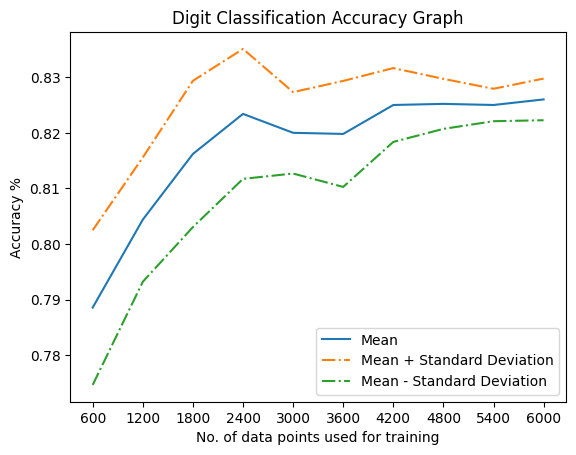

In [35]:
x = [600*i for i in range(1,11)]

plt.plot(x, Mean, label="Mean")
plt.plot(x, high,'-.', label="Mean + Standard Deviation")
plt.plot(x, low, '-.', label="Mean - Standard Deviation")
plt.xticks(x)

plt.ylabel('Accuracy %')
plt.xlabel('No. of data points used for training')
plt.title("Digit Classification Accuracy Graph")
plt.legend()
plt.show()

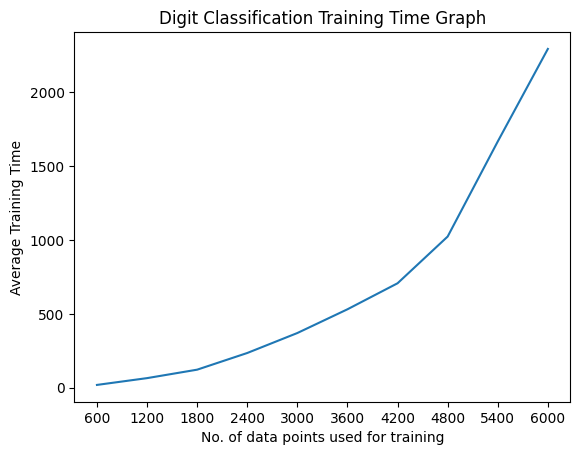

In [36]:

plt.plot(x,Time)
plt.xticks(x)
plt.ylabel('Average Training Time')
plt.xlabel('No. of data points used for training')
plt.title("Digit Classification Training Time Graph")
plt.show()

# Neural Networks

### Training on entire dataset

In [37]:
data = pd.read_csv(r"./data/digitdata/fortyninetrainfeatures.csv")
data_validation = pd.read_csv(r"./data/digitdata/fortyninevalidationfeatures.csv")
data_test = pd.read_csv(r"./data/digitdata/fortyninetestfeatures.csv")

In [38]:
labels = ['G0', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6','G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16','G17', 'G18', 'G19', 'G20', 'G21', 'G22', 'G23', 'G24', 'G25',
        'G26', 'G27', 'G28', 'G29', 'G30', 'G31', 'G32', 'G33', 'G34','G35', 'G36', 'G37', 'G38', 'G39', 'G40', 'G41', 'G42', 'G43',
        'G44', 'G45', 'G46', 'G47', 'G48']

In [39]:
Xtr = data[labels]
Ytr = data['Label']

Xtr_valid = data_validation[labels]
Ytr_valid = data_validation['Label']

In [40]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Ytr)
encoded_Y = encoder.transform(Ytr)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Ytr_valid)
encoded_Y = encoder.transform(Ytr)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_valid = np_utils.to_categorical(encoded_Y)

In [41]:
dnn_model = Sequential()
dnn_model.add(Dense(64,input_dim=49,activation='relu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dense(32, activation='relu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dense(16, activation='relu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dense(8, activation='relu'))
dnn_model.add(BatchNormalization())
#Final dense layer on which softmax function is performed
dnn_model.add(Dense(10, activation='softmax'))

In [42]:
start_time = time.time()
dnn_model.compile(loss='categorical_crossentropy',optimizer='adamax',metrics=['accuracy'])

In [43]:
history = dnn_model.fit(Xtr, dummy_y, shuffle = True, validation_steps = ((Xtr_valid,dummy_y_valid)),epochs =100)

Epoch 1/100
157/157 [==============================] - 2s 2ms/step - loss: 2.1681 - accuracy: 0.2676
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - loss: 1.6547 - accuracy: 0.4814
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - loss: 1.3871 - accuracy: 0.5976
Epoch 4/100
157/157 [==============================] - 0s 2ms/step - loss: 1.2130 - accuracy: 0.6626
Epoch 5/100
157/157 [==============================] - 0s 2ms/step - loss: 1.0552 - accuracy: 0.7068
Epoch 6/100
157/157 [==============================] - 0s 2ms/step - loss: 0.9341 - accuracy: 0.7566
Epoch 7/100
157/157 [==============================] - 0s 2ms/step - loss: 0.8498 - accuracy: 0.7722
Epoch 8/100
157/157 [==============================] - 0s 2ms/step - loss: 0.7725 - accuracy: 0.7906
Epoch 9/100
157/157 [==============================] - 0s 2ms/step - loss: 0.7071 - accuracy: 0.8104
Epoch 10/100
157/157 [==============================] - 0s 2ms/step - loss: 0.6523 - accura

### Testing after training on entire dataset

In [44]:

Xtr_test = data_test[labels]
Ytr_test = data_test['Label']

# encode class values as integers
encoder_test = LabelEncoder()
encoder_test.fit(Ytr_test)
encoded_Y = encoder_test.transform(Ytr_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y)

In [45]:
Ytr_test.value_counts()

1    108
4    107
7    106
8    103
2    103
9    100
3    100
5     92
6     91
0     90
Name: Label, dtype: int64

In [46]:
predictions = dnn_model.predict(Xtr_test)

32/32 [==============================] - 0s 1ms/step


In [47]:
y_pred_test = []
for i in range(len(predictions)):
    y_pred_test.append(np.argmax(predictions[i]))

In [48]:
y_pred_test = pd.DataFrame(y_pred_test)
time_taken = time.time() - start_time

In [49]:
print("Time Taken:",time_taken)

Time Taken: 29.777352571487427


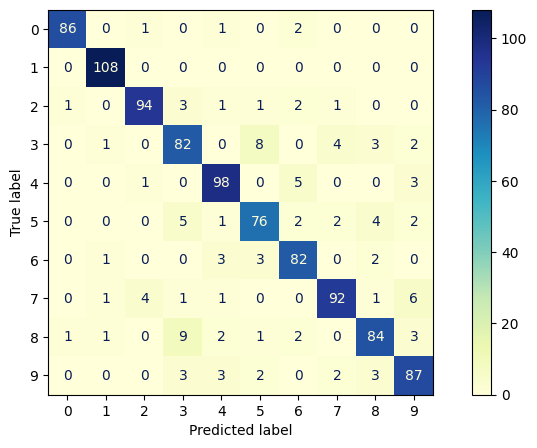

In [50]:
labels_1 = list(range(10))

cf_mtx = confusion_matrix(Ytr_test, y_pred_test)
img = ConfusionMatrixDisplay(cf_mtx, display_labels=labels_1)
_, ax = plt.subplots(figsize=(10,5))
img.plot(ax=ax,cmap="YlGnBu")
plt.show()

In [51]:
print(classification_report(Ytr_test, y_pred_test, target_names=["0","1","2","3","4","5","6","7","8","9"]))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        90
           1       0.96      1.00      0.98       108
           2       0.94      0.91      0.93       103
           3       0.80      0.82      0.81       100
           4       0.89      0.92      0.90       107
           5       0.84      0.83      0.83        92
           6       0.86      0.90      0.88        91
           7       0.91      0.87      0.89       106
           8       0.87      0.82      0.84       103
           9       0.84      0.87      0.86       100

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



### Training on subdivisions of dataset

In [ ]:
mean_list = []
std_low = []
std_high = []
time_list = []
no_of_datapoints = []
data_split = data.append(data_validation)

for per in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    j = 0
    accuracy_list = []
    temp_times = []
    for j in range(5):
        
        sample_training_df  = data_split.sample(frac=per, random_state=j)
        sample_training_df  = sample_training_df.sort_values('Label')
        
        X_train = sample_training_df[labels]
        y_train = sample_training_df['Label']
        
        print(len(X_train))
        dnn_model = Sequential()
        dnn_model.add(Dense(64,input_dim=49,activation='relu'))
        dnn_model.add(BatchNormalization())
        dnn_model.add(Dense(32, activation='relu'))
        dnn_model.add(BatchNormalization())
        dnn_model.add(Dense(16, activation='relu'))
        dnn_model.add(BatchNormalization())
        dnn_model.add(Dense(8, activation='relu'))
        dnn_model.add(BatchNormalization())
        #Final dense layer on which softmax function is performed
        dnn_model.add(Dense(10, activation='softmax'))

        # encode class values as integers
        encoder = LabelEncoder()
        encoder.fit(y_train)
        encoded_Y = encoder.transform(y_train)
        # convert integers to dummy variables (i.e. one hot encoded)
        dummy_y = np_utils.to_categorical(encoded_Y)


        start_time = time.time()
        dnn_model.compile(loss='categorical_crossentropy',optimizer='adamax',metrics=['accuracy'])
        history = dnn_model.fit(X_train, dummy_y,epochs =100)

        predictions = dnn_model.predict(Xtr_test)

        y_pred_test = []

        for i in range(len(predictions)):
            y_pred_test.append(np.argmax(predictions[i]))
        y_pred_test = pd.DataFrame(y_pred_test)
        a = accuracy_score(Ytr_test, y_pred_test)
        accuracy_list.append(a)
        temp_times.append(time.time() - start_time)
        j = j+1
    
    print(accuracy_list)
    print()
    no_of_datapoints.append(len(X_train))
    time_list.append(statistics.mean(temp_times))
    mean = statistics.mean(accuracy_list)
    mean_list.append(mean)
    std_dev = statistics.stdev(accuracy_list)
    std_low.append(mean-std_dev)
    std_high.append(mean+std_dev)


600
Epoch 1/100
19/19 [==============================] - 2s 2ms/step - loss: 2.4459 - accuracy: 0.1567
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 2.2037 - accuracy: 0.2250
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 2.0742 - accuracy: 0.2633
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 2.0111 - accuracy: 0.2983
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: 1.8931 - accuracy: 0.3750
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 1.8290 - accuracy: 0.3883
Epoch 7/100
19/19 [==============================] - 0s 2ms/step - loss: 1.7745 - accuracy: 0.4400
Epoch 8/100
19/19 [==============================] - 0s 2ms/step - loss: 1.7084 - accuracy: 0.4483
Epoch 9/100
19/19 [==============================] - 0s 2ms/step - loss: 1.6753 - accuracy: 0.4650
Epoch 10/100
19/19 [==============================] - 0s 3ms/step - loss: 1.6264 - accuracy: 0.4917
Epoch

In [ ]:
mean_list

[0.7568,
 0.8211999999999999,
 0.8351999999999999,
 0.866,
 0.875,
 0.8858,
 0.8828,
 0.8928,
 0.8992,
 0.9056000000000001]

In [ ]:
no_of_datapoints

[600, 1200, 1800, 2400, 3000, 3600, 4200, 4800, 5400, 6000]

### Plotting Results

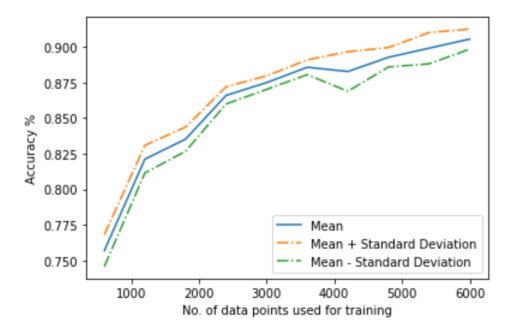

In [31]:
# Plot the graph of mean and standard deviation
plt.plot(no_of_datapoints, mean_list,label="Mean")
plt.plot(no_of_datapoints, std_high,'-.',label="Mean + Standard Deviation")
plt.plot(no_of_datapoints, std_low,'-.', label="Mean - Standard Deviation")
plt.xlabel("No. of data points used for training")
plt.ylabel("Accuracy %")
plt.legend()
plt.show()


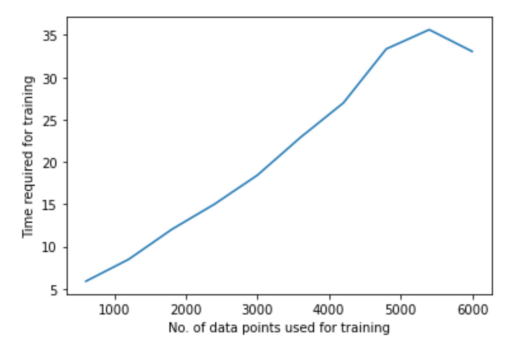

In [32]:
# Running time graph
plt.plot(no_of_datapoints, time_list)
plt.xlabel("No. of data points used for training")
plt.ylabel("Time required for training")
plt.show()

# Prediction for a single value from testing data 

In [52]:
random_state_value = 1

### Naive Bayes Classifier

Prediction: 7 
Actual Label: 7


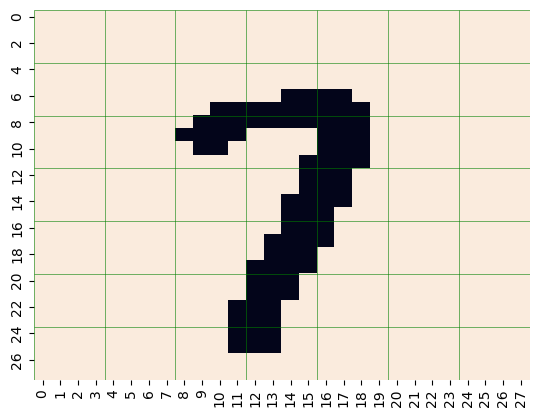

In [53]:
rand_test_df = testing_data_df.sample(random_state=random_state_value)
prediction, label = random_naive_test(rand_test_df, probability_of_features, probability_of_labels)
image = json.loads(rand_test_df.Image_data.to_list()[0])
seaborn.heatmap(image,cbar=False, cmap='rocket_r')
# To represent each subgroup
for i in range(0,28,4):
    plt.hlines(i,0,60,linewidth=0.4,color='g')
for j in range(0,28,4):
    plt.vlines(j,0,70,linewidth=0.4,color='g')
print("Prediction:", prediction, "\nActual Label:", label)
plt.show()

### Perceptron

In [54]:
weights_df = pd.read_csv(filepath+"/weights/weightsnew.csv", index_col=False)
weights_df['Weights'] = weights_df['Weights'].apply(json.loads)
weights = weights_df['Weights'].tolist()

Prediction: 7 
Actual Label: 7


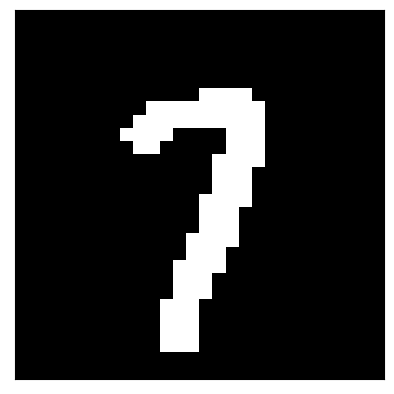

In [55]:
rand_test_df = test_df.sample(random_state=random_state_value)
prediction, label = random_perceptron_test(rand_test_df, weights)
image = rand_test_df.iloc[0][0]
print("Prediction:", prediction, "\nActual Label:", label)
display_image(image)

### Neural Network

1/1 [==============================] - 0s 21ms/step
Prediction: 7 
Actual Label: 7


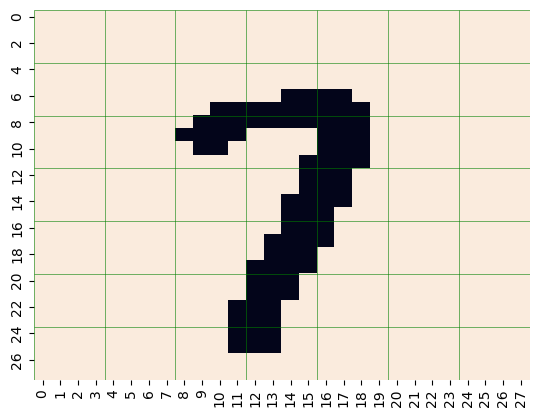

In [56]:
X_test_sample = data_test.sample(random_state=random_state_value)
label = X_test_sample.iloc[0][1]
image =  json.loads(X_test_sample.Image_data.to_list()[0])
prediction = np.argmax(dnn_model.predict(X_test_sample[labels]))
seaborn.heatmap(image,cbar=False,cmap='rocket_r')
# To represent each subgroup
for i in range(0,28,4):
    plt.hlines(i,0,28,linewidth=0.4,color='g')
for j in range(0,28,4):
    plt.vlines(j,0,28,linewidth=0.4,color='g')
print("Prediction:", prediction, "\nActual Label:", label)
plt.show()